# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
# Import necessary modules
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

In [5]:
cv2.__version__

'3.4.1'

In [4]:
import os
import cv2
import matplotlib.mlab
from collections import defaultdict
from functools import reduce

from skimage import measure
from scipy.optimize import curve_fit
from scipy.signal import medfilt
from scipy.stats import norm

In [6]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

# Load data

In [9]:
# Load images 
os.listdir('../data/project-data/')
data_dir = '../data/project-data/'

img_dict = dict()
gt_dict = dict()
img_types = ['train', 'validation', 'test']

for img_type in img_types:
    
    # Get file names
    with open(f'{data_dir}/{img_type}.txt', 'r') as f:
        
        filenames = f.read().split('\n')
        
    # Get images
    img_dict[img_type] = skimage.io.imread_collection([f'{data_dir}/images/{img_type}/{img_name}.jpg'
                                                      for img_name in filenames])
    
    # Get groundtruth
    gt_dict[img_type] = [parse_file(f'{data_dir}/annotations/{img_type}/{img_name}.xml')
                        for img_name in filenames]
    

# 1. Thresholding

In [6]:
# Get histogram of pixel values
k = 11
gray_img = skimage.color.rgb2gray(img_dict['train'][k]) * 256

## 1.1 Preprocess by smoothing

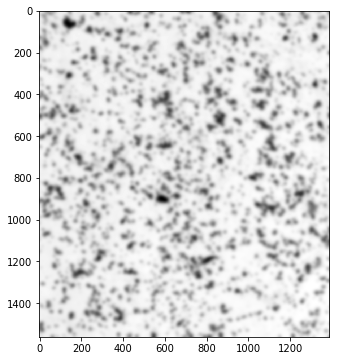

In [122]:
from scipy.signal import wiener

from scipy.ndimage.filters import gaussian_filter

tmp_median_smoothed = gaussian_filter(gray_img, 8)

fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)
ax.imshow(tmp_median_smoothed, cmap = 'gray')

Unclear whether smoothing is useful. Need more investigation.

## 1.2 Find threshold to separate foreground and background

1. Gaussian fitting
  Fit gaussian to the gray level histogram and find the intersection of two gaussian as separating threshold.

2. Heuristic method
  Decide the threshold based on heuristics. 

In [123]:
def gauss(x, mean, sigma, A):
    
    return A * np.exp(-1 * (x - mean) ** 2 / (2 * sigma ** 2))

def bimodal(x, mean_f, sigma_f, A_f, mean_b, sigma_b, A_b):
    
    return gauss(x, mean_f, sigma_f, A_f) + gauss(x, mean_b, sigma_b, A_b)

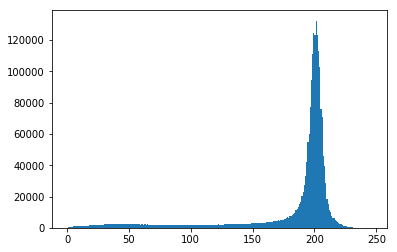

In [124]:
# Get count of pixels for each bins of gray values
counts, bins, _ = plt.hist(gray_img.ravel(), bins = 256)

In [125]:
# Initialize fore/back ground separation boundary
thrs_estimated = 100

In [126]:
# Fit gaussian to the white part
white_params, _ = curve_fit(gauss, np.arange(256 - thrs_estimated), counts[thrs_estimated: ])

# Fit gaussian to black part
black_params, _ = curve_fit(gauss, np.arange(thrs_estimated), counts[: thrs_estimated])

Text(0.5, 1.0, 'Black')

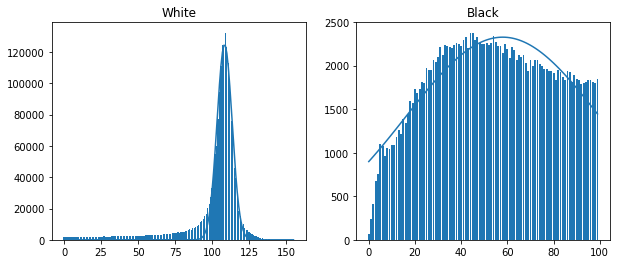

In [127]:
# Visualize the gaussian fit
fig = plt.figure(figsize = (10, 4))

# Plot white part
ax = fig.add_subplot(121)
ax.bar(np.arange(256 - thrs_estimated), counts[thrs_estimated:])
ax.plot(np.arange(256 - thrs_estimated), gauss(np.arange(256 - thrs_estimated), *white_params))
ax.set_title('White')

# Plot black part
ax = fig.add_subplot(122)
ax.bar(np.arange(thrs_estimated), counts[: thrs_estimated])
ax.plot(np.arange(thrs_estimated), gauss(np.arange(thrs_estimated), *black_params))
ax.set_title('Black')

In [128]:
# Find the threshold minimizing classification into foreground and background
def find_gaussian_intersection(mean_1, sigma_1, A_1, mean_2, sigma_2, A_2):
    """
    Find value where two gaussian have same probability
    Params: mean_1: mean of first gaussian
            sigma_1: std of first gaussian
            A_1: amplitude of first gaussian
            mean_2: mean of second gaussian
            sigma_2: std of second gaussian
            A_2: amplitude of second gaussian
    Return: intersection value
    """
    
    # Reduce the problem of solving a quadratic equation
    
    # Find second order param
    sec_param = (1 / (2 * sigma_2 ** 2) - 1 / (2 * sigma_1 ** 2))

    # Find first order param
    first_param = mean_1 / sigma_1 ** 2 - mean_2 / sigma_2 ** 2

    # Find constant param
    constant_param = mean_2 ** 2 / (2 * sigma_2 ** 2) - mean_1 ** 2 / (2 * sigma_1 ** 2) + \
                        np.log(A_1) - np.log(A_2)
    
    return np.roots([sec_param, first_param, constant_param])[1]

In [129]:
# Get threshold of foreground and background
thrs = find_gaussian_intersection(*white_params, *black_params)

In [130]:
print(f'Gaussian fitting results in separation threshold of {thrs}')

Gaussian fitting results in separation threshold of 93.42003788381324


In [131]:
# Map the image to binary img using threshold
bi_img = gray_img < thrs

Text(0.5, 1.0, 'Filtered by heuristic')

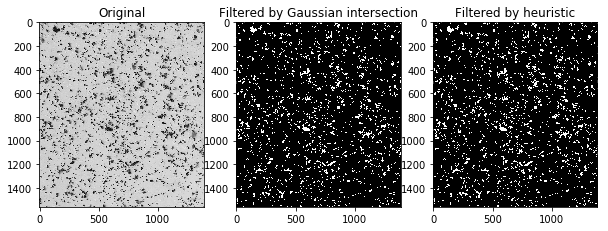

In [132]:
# Test the effect of thrs obtained from gaussian intersection
fig = plt.figure(figsize = (10, 4))
ax_list = fig.subplots(1, 3)

ax_list[0].imshow(gray_img, cmap = 'gray')
ax_list[1].imshow(bi_img, cmap = 'gray')
ax_list[2].imshow(gray_img < 100, cmap = 'gray')

ax_list[0].set_title('Original')
ax_list[1].set_title('Filtered by Gaussian intersection')
ax_list[2].set_title('Filtered by heuristic')

It is unclear whether Gaussian will outperform by heuristics as shown in the above comparisons.

For simplicity we continue with heuristics threshold.

In [12]:
# Set heuristic threshold
thrs = 100

# Get binary image by heuristic threshold
bi_img = gray_img < thrs

## 1.2 Label objects

1.2.1 Label objects using measure.label method provided in skimage module

1.2.2 Get features of detected objs including size and bounding rectangle

### 1.2.1 Conduct primitive labeling

In [168]:
# Get labels
labels = measure.label(bi_img)

In [169]:
# Illustrate labels
print(f'number of objects found are {np.max(labels) + 1}')

number of objects found are 2408


The above count show that primitive labeling cannot distinguish vorroa objs from the others since we only have tens of vorroas in an image generally.

### 1.2.2 Get size and bounding rectangle of each object

In [170]:
# Get size of detected objs
obj_sizes = dict(zip(*np.unique(labels, return_counts = True)))

# Build list of pixels for each obj
obj_pixels_alt = defaultdict(list)

for i in range(labels.shape[0]):
    
    for j in range(labels.shape[1]):
        
        obj_pixels_alt[labels[i][j]].append((i, j))

# Compute the covering rect of detected objs
obj_bbox = {k : np.asarray(cv2.boundingRect(np.asarray(obj_pixels_alt[k])))[[1, 0, 3, 2]]
            for k, v in obj_pixels_alt.items()}

# Get the area of bounding rectangle for each detected obj
obj_bbox_size = {k : obj_bbox[k][2] * obj_bbox[k][3] for k in obj_bbox.keys()}

Text(0.5, 1.0, 'Log-Log histogram of size of detected objs')

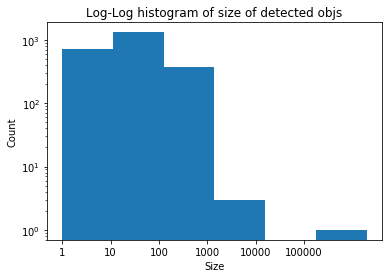

In [171]:
# Visualize the size distribution of objects
plt.hist(np.log10(list(obj_sizes.values())),
          bins = 6,
        log = True)
_ = plt.xticks(np.arange(6), [f'{10 ** s}' for s in np.arange(6)])
plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Log-Log histogram of size of detected objs')

From the distribution of size one can observe that there are two types of objs detected that should be regarded as vorroas:

1. objects with extreme large size: these objects may be background or some unrelated objects

2. objects with extreme small size: these objects may be measurement noise

The above findings motivate us to find the thresholds for filtering objects by size.

## 1.3 Filter objects by size

1. Set thresholds by checking the distribution of vorroa's sizes in training data
2. Filter objects that are likely to be vorroa using aforementioned thresholds

### 1.3.1 Find distribution of size of vorroa

In [20]:
# Check avg vorroa size
avg_size_list = []

for i, img in enumerate(np.random.choice(gt_dict['train'], size = 500, replace = False)):
    
    # Add avg of vorroa size in this img to list
    try:
        
        avg_size_list += reduce(lambda l, item: l + [item['bbox'][2] * item['bbox'][3]],
                                   img,
                                    [])
    
    except:
        
        pass

In [21]:
# Get mean and var of size of vorroa obj
size_mean = np.mean(avg_size_list)

size_std = np.std(avg_size_list)

Text(0.5, 1.0, 'Groundtruth vorroa size distribution')

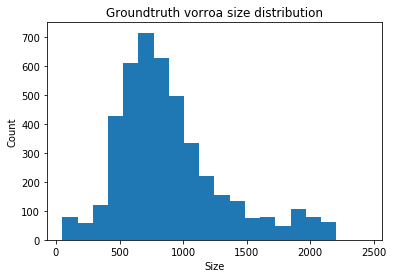

In [164]:
# Visualize the vorroa size distribution
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.hist(avg_size_list, bins = 20)
ax.set_xlabel('Size')
ax.set_ylabel('Count')
ax.set_title('Groundtruth vorroa size distribution')

Assume that vorroa are located pairwisely independent,
Chebshev inequility indicates that by taking the size thrs to be $\mu + 3\sigma$,
we can capture about $90\%$ of vorroa objects.

So we may set the upper bound of size of an valid vorroa obj to be that value.

In [22]:
# Set upper size threshold
up_size_thrs = size_mean + 3 * size_std

By heuristics we may set the lower bound of size of an valid vorroa to be 350.

In [204]:
# Set lower size threshold
low_size_thrs = np.float64(350)

### 1.3.2 Filter detected obj based on size thresholds found.

In [205]:
# Filter the detected obj by size_thrs
obj_mask = np.where((list(obj_sizes.values()) > low_size_thrs) *\
                    (list(obj_sizes.values()) < up_size_thrs),
                    1,
                    0)

In [206]:
# Get the filtered objs
obj_bbox_values = list(obj_bbox.values())
filtered_objs = np.asarray([obj_bbox_values[i] for i in range(len(obj_mask)) if obj_mask[i]])

Text(0.5, 1.0, 'Groundtruth: Red   Detected: Steelblue')

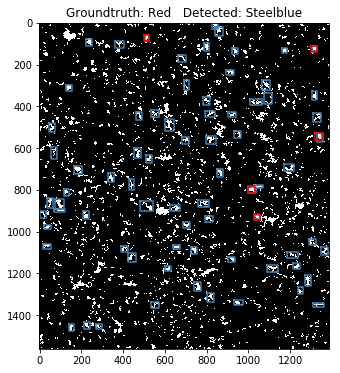

In [216]:
# Visualize the filtered objs on the binary figure
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)

# Show img
ax.imshow(bi_img, cmap = 'gray')

# Show detected objs
for obj in filtered_objs:
    
    ax.plot([obj[0], obj[0] + obj[2], obj[0] + obj[2], obj[0], obj[0]],
           [obj[1], obj[1], obj[1] + obj[3], obj[1] + obj[3], obj[1]],
           c = 'steelblue')

# Show ground truth obj
gt_objs = [item['bbox'] for item in gt_dict['train'][k]]

for obj in gt_objs:
    
    ax.plot([obj[0], obj[0] + obj[2], obj[0] + obj[2], obj[0], obj[0]],
       [obj[1], obj[1], obj[1] + obj[3], obj[1] + obj[3], obj[1]],
       c = 'red')

ax.set_title('Groundtruth: Red   Detected: Steelblue')

## 1.4 Evaluation

Evaluate our segmentation results by calculating precision, recall and f1 score.

In [88]:
def calculate_IoU(a, b):
    """
    Calculate the IoU of a and b
    Params: a: (a.x, a.y, a.w, a.h)
            b: (b.x, b.y, b.w, b.h)
    Return: IoU(a, b)
    """
    
    # Calculate intersection area
    dx = min(a[0] + a[2], b[0] + b[2]) - max(a[0], b[0])
    dy = min(a[1] + a[3], b[1] + b[3]) - max(a[1], b[1])
    
    # Return zero if no intersection
    if dx <= 0 or dy <= 0:
        return 0
    
    # Set intersection area
    int_area = dx * dy
    
    # Calculate union length
    uni_area = a[2] * a[3] + b[2] * b[3] - int_area
    
    return int_area / uni_area 

In [190]:
def cal_stats(values, thrs, gtl):
    """
    Calculate precision, recall and f1_score for given thrshold
    Param: values : np.array
           thrs : double
           gtl : length of ground truth
    Return: (prec, recall, f1_score)
    """
    
    # Get boolean judgment for values using thrs
    results = np.asarray(values) > thrs
    
    # Get prec
    prec = np.sum(results) / len(values)
    
    # Get rec
    rec = np.sum(results) / gtl
    
    # Get f1_score
    f1 = 2 * prec * rec / (prec + rec)
    
    return (prec, rec, f1)

In [191]:
# Get the max IoU score for each filtered detected obj
iou_scores = [np.max([calculate_IoU(detected, gt) for gt in gt_objs]) for detected in filtered_objs]

In [192]:
# Get statistics for current img
prec, rec, f1 = cal_stats(iou_scores, thrs = 0.3, gtl = len(gt_objs))

In [193]:
print(f'Precision: {prec}\nRecall: {rec}\nF1: {f1}')

Precision: 0.0625
Recall: 1.0
F1: 0.11764705882352941


## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [59]:
THRS = 100
UP_SIZE_THRS = np.float64(2164.0)
LOW_SIZE_THRS = np.float64(350.0)

In [60]:
def detect_by_segmentation(img, thrs = THRS, up_size_thrs = UP_SIZE_THRS, low_size_thrs = LOW_SIZE_THRS):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    ''' Separate foreground and background '''
    
    # Convert img to gray scale
    gray_img = gray_img = skimage.color.rgb2gray(img) * 256
    
    # Filter img
    bi_img = gray_img < thrs
    

    ''' Label objects '''
    # Get labels
    labels = measure.label(bi_img)

    # Get size of detected objs
    obj_sizes = dict(zip(*np.unique(labels, return_counts = True)))
    
    # Formulate obj as list of pixels
    obj_pixels = defaultdict(list)

    for i in range(labels.shape[0]):

        for j in range(labels.shape[1]):

            obj_pixels[labels[i][j]].append((i, j))
            

    ''' Filter objs based on size'''
    # Compute the bounding rect of detected objs
    obj_bbox = {k : np.asarray(cv2.boundingRect(np.asarray(obj_pixels[k])))[[1, 0, 3, 2]]
                for k, v in obj_pixels.items()}

    # Filter the detected obj by size_thrs
    obj_mask = np.where((list(obj_sizes.values()) > low_size_thrs) *\
                        (list(obj_sizes.values()) < up_size_thrs),
                        1,
                        0)

    # Get the filtered objs
    obj_bbox_values = list(obj_bbox.values())
    filtered_objs = np.asarray([obj_bbox_values[i] for i in range(len(obj_mask)) if obj_mask[i]])
    
    return filtered_objs

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [76]:
# Get test imgs
test_imgs = img_dict['test']

# Get test groundtruth
test_gt = gt_dict['test']

# Get number of ground truth objs
gtl = reduce(lambda current_length, next_item: current_length + len(next_item), test_gt, 0)

# Initialize iou_scores
iou_scores_all = []

# Loop through all img to detect vorroas
for i, img in enumerate(test_imgs):
    
    # Get detected objs
    detected_objs = detect_by_segmentation(img)
    
    # Get groundtruth
    gt_img = [item['bbox'] for item in test_gt[i]]
    
    # Compute max IoU score for each detected obj
    iou_scores = [np.max([calculate_IoU(detected, gt) for gt in gt_img]) if len(gt_img) > 0 else 0 \
                  for detected in detected_objs]
    
    # Append results for this img to total results
    iou_scores_all += iou_scores

# Calculating statistics
prec, rec, f1 = cal_stats(iou_scores_all, thrs = 0.3, gtl = gtl)

In [80]:
print(f'Precision: {prec}\nRecall: {rec}\nF1: {f1}')

Precision: 0.09903121636167922
Recall: 0.4742268041237113
F1: 0.163846838824577


## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

## 2.1 Prepare data

From the vorroa size distribution, one may convince himself that setting the sliding window with length 72 and width 72 sufficies to detect all feasible vorroas.

In [26]:
def rolling_window(a, window, step_size):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1 - step_size, window)
    strides = a.strides + (a.strides[-1] * step_size,)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


In [295]:
def generate_crops(img, targets, step, stride):
    """
    Generate crops with window_shape from img
    Params: img: np.array
            targets: list of vorroa box
            step: window step
            stride: window stride
    Return: list of crops and label while 1 represent vorroa and 0 otherwise
    """
    
    # Get groundtruth boxes from targets
    gt_box = [item['bbox'] for item in targets]
    
    # Get bounding boxes for img
    windows = list(zip(*map(lambda x: x.ravel(),
                            np.meshgrid(np.arange(0, img.shape[0] - step + 1, step / stride),
                                          np.arange(0, img.shape[1] - step + 1, step / stride),
                                                  indexing = 'ij'))))
    
    windows = np.concatenate([windows, [[step, step]] * len(windows)], axis = 1)

    # Get label for each bounding box using IoU
    try:
        
        # Handle the case where img contains vorroa
        labels = [np.max([calculate_IoU(detected, gt) for gt in gt_box]) > 0.3 for detected in windows]
    
    except:
        
        # Handle the case where img does not contain vorroa
        labels = [0] * len(windows)
        
    # Get window crops
    window_crops = np.lib.stride_tricks.as_strided(img,
                                                shape = [len(np.arange(0, 
                                                                       img.shape[0] - step + 1,
                                                                       step / stride)),
                                                         len(np.arange(0, 
                                                                       img.shape[1] - step + 1,
                                                                       step / stride)), 
                                                         step,
                                                         step,
                                                         3],
                                                strides = [step // stride * img.strides[0],
                                                          step // stride * img.strides[1],
                                                          img.strides[0],
                                                          img.strides[1],
                                                          img.strides[2]])

    # Reshape window crops and labels
    window_crops = window_crops.reshape(-1, step, step, 3)
    labels = np.asarray(labels)
    
    ''' Randomly drop some non vorroa windows'''
    
    # Get vorroa window and non vorroa window indices
    vorroa_indices = np.where(labels == 1)[0]
    
    non_vorroa_indices = np.where(labels == 0)[0]
    
    # Get indices of 100 non-vorroa windows to keep
    keep_non_vorroa_indices = non_vorroa_indices[np.random.randint(0, len(non_vorroa_indices), 100)]
    
    # Construct windows and labels to return
    window_crops = window_crops[np.concatenate([vorroa_indices, keep_non_vorroa_indices])]
    
    labels = labels[np.concatenate([vorroa_indices, keep_non_vorroa_indices])]
    
    return window_crops, labels

In [306]:
# Get training data
results = [generate_crops(img_dict['train'][i],
                                       gt_dict['train'][i],
                                       step = 48,
                                       stride = 2) for i in range(800)]

results = np.asarray(results)

# Reshape windows and labels
window_crops = results[:, 0]

window_crops = np.concatenate(window_crops)

labels = np.concatenate(results[:, 1])

In [319]:
# Store data to file
np.save('window_crops', window_crops)

np.save('labels', labels)

In [3]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [4]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

### 3.0 Initialization

In [5]:
# Import necessary modules
import tensorflow as tf

In [6]:
tf.logging.set_verbosity(tf.logging.INFO)

In [328]:
# Define window shape
window_height = 48
window_width = 48

### 3.1 Build training and validation data

In [310]:
# Set train_validation split ratio
train_val_ratio = 0.8

# Shuffle data
shuffle_indices = np.random.permutation(np.arange(labels.shape[0]))

window_crops = window_crops[shuffle_indices]

labels = labels[shuffle_indices]

In [314]:
# Get positive and negative indices
positive_indices = np.where(labels == 1)[0]

negative_indices = np.where(labels == 0)[0]

# Get train and validation indices
train_indices = np.concatenate([positive_indices[: int(train_val_ratio * len(positive_indices))],
                               negative_indices[: int(train_val_ratio * len(negative_indices))]])

val_indices = np.concatenate([positive_indices[int(train_val_ratio * len(positive_indices)) :],
                               negative_indices[: int(train_val_ratio * len(negative_indices)) :]])

# Build training data
x_train = window_crops[train_indices]

y_train = labels[train_indices]

# Build validation data
x_val = window_crops[val_indices]

y_val = labels[val_indices]

In [362]:
# For testing purpose filter training data
filter_indices = np.random.randint(0, len(x_train), 5000)
x_filtered_train = x_train[filter_indices]
y_filtered_train = y_train[filter_indices]

In [412]:
# Create cnn model function
def cnn_model_fn(features, labels, mode):
    
    # Create input layer
    input_layer = tf.reshape(features, [-1, window_height, window_width, 3])
    
    # Convolutional layer 1
    conv1 = tf.layers.conv2d(inputs = input_layer,
                            filters = 32,
                            kernel_size = (5, 5),
                            padding = 'same',
                            activation = tf.nn.relu)
    
    # Max pooling layer 1
    pool1 = tf.layers.max_pooling2d(inputs = conv1,
                                   pool_size = (2, 2),
                                   strides = 2)
    
    # Convolutional layer 2
    conv2 = tf.layers.conv2d(inputs = pool1,
                            filters = 64,
                            kernel_size = (5, 5),
                            padding = 'same',
                            activation = tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs = conv2, 
                                   pool_size = (2, 2),
                                   strides = 2)
    
    # Dense layer
    pool2_flat = tf.reshape(pool2, [-1, window_height * window_width * 64 // 16])
    
    dense = tf.layers.dense(inputs = pool2_flat, 
                           units = 1024,
                           activation = tf.nn.relu)
    
    dropout = tf.layers.dropout(inputs = dense,
                               rate = 0.4, 
                               training = (mode == tf.estimator.ModeKeys.TRAIN))
    
    # Decision layer
    logits = tf.layers.dense(inputs = dropout,
                            units = 2)
    
    # Generate predictions
    predictions = {
        
        # Generate class labels
        'classes' : tf.argmax(logits, axis = 1),
        
        # Generate probabilities
        'probabilities' : tf.nn.softmax(logits, name = 'softmax_tensor')
    }
    
    # Handle prediction
    if mode == tf.estimator.ModeKeys.PREDICT:
        
        return tf.estimator.EstimatorSpec(mode = mode,
                                         predictions = predictions)
    
    # Calculate loss
    losses = tf.losses.sparse_softmax_cross_entropy(labels = labels,
                                            logits = logits)
    
    # Configure training
    if mode == tf.estimator.ModeKeys.TRAIN:
        
        # Define optimizer
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 1e-3)
        
        # Define train operation
        train_op = optimizer.minimize(loss = losses,
                                     global_step = tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(mode = mode,
                                         loss = losses, 
                                         train_op = train_op)
    
    # Configure evaluation 
    if mode == tf.estimator.ModeKeys.EVAL:
        
        # Define evaluation metric operation
        eval_metric_ops = {
            
            'accuracy' : tf.metrics.accuracy(labels = labels,
                                            predictions = predictions['classes'])
        }
        
        return tf.estimator.EstimatorSpec(mode = mode,
                                         eval_metric_ops = eval_metric_ops)

In [413]:
# Create estimator
classifier = tf.estimator.Estimator(model_fn = cnn_model_fn,
                                   model_dir = './cnn_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './cnn_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f56983e8828>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [414]:
# Create logger
tensors_to_log = {'probabilities' : 'softmax_tensor'}
logging_hook = tf.train.LoggingTensorHook(tensors = tensors_to_log,
                                         every_n_iter = 50)

In [415]:
# Convert train data to float
x_filtered_train = x_filtered_train / np.float32(255)

KeyboardInterrupt: 

In [423]:
# Convert class to int
y_filtered_train = y_filtered_train.astype(np.int32)

In [424]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(\
                                                    x = x_filtered_train,
                                                    y = y_filtered_train,
                                                    batch_size = 100,
                                                    num_epochs = None,
                                                    shuffle = True)

In [425]:
# Train one step and display the probabilities
classifier.train(input_fn = train_input_fn, 
                steps = 1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./cnn_model/model.ckpt-1001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1001 into ./cnn_model/model.ckpt.
INFO:tensorflow:loss = 0.28234655, step = 1002
INFO:tensorflow:global_step/sec: 1.42607
INFO:tensorflow:loss = 0.27983782, step = 1102 (70.758 sec)
INFO:tensorflow:global_step/sec: 1.33155
INFO:tensorflow:loss = 0.24495429, step = 1202 (74.481 sec)
INFO:tensorflow:global_step/sec: 1.8721
INFO:tensorflow:loss = 0.3743868, step = 1302 (53.375 sec)
INFO:tensorflow:global_step/sec: 1.87202
INFO:tensorflow:loss = 0.25703394, step = 1402 (53.418 sec)
INFO:tensorflow:global_step/sec: 1.87
INFO:tensorflow:loss = 0.33119556, step = 1502 (53.476 sec)
INFO:tensorflow:global_step/sec: 1.83878
INFO:tensorflow:loss = 0.2533689

In [392]:
# Build validation data

# Convert x_val to double
x_val = x_val.astype(np.float32)

# Convert y to be of shape (1, 2)
y_val = np.ones((len(y_val), 2)) * np.transpose([-y_val + 1, y_val])

In [405]:
# Validation
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x = x_val,
                                                   y = y_val,
                                                   num_epochs = 1,
                                                   shuffle = False
                                                  )


In [ ]:
tf.keras.datasets.mnist.load_data()

In [406]:
eval_results = classifier.evaluate(input_fn = eval_input_fn)

INFO:tensorflow:Calling model_fn.


ValueError: Shapes (?, 2) and (?,) are incompatible

In [398]:
y_filtered_train[: 5]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code